In [1]:
__license__   = "GNU GPLv3 <https://www.gnu.org/licenses/gpl.txt>"
__copyright__ = "2022, Joseph Kuruvilla"
__author__    = "Joseph Kuruvilla"
__version__   = "0.1"

In [2]:
# -------------------
#  Importing Modules
# -------------------

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split

import scipy
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

import camb
from camb import model, initialpower

In [3]:
# ------------------------------
#  Global variables declaration
# ------------------------------

kmin = 1e-4
kmax = 15

s8_fid = 0.8102

In [4]:
def pk_camb(HH0, kmin, kmax, Npoints, s8_fid):
    """Function to compute the power spectrum from CAMB
    Inputs:
    ---------------------------------------------------
    HH0: Hubble factor (in ) [float]
    kmin: Minimum wavelength (in h/Mpc) [float]
    kmax: Minimum wavelength (in h/Mpc) [float]
    Npoints: Number of bins [int]
    s8_fid: Fiducial sigma8 value [float]
    
    Returns:
    ---------------------------------------------------
    output_pk: The computed power spectrum for the 
                cosmology specified [numpy array]
    
    """
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=HH0, ombh2=0.02242, omch2=0.11933)
    pars.InitPower.set_params(As=2.105209331e-9, ns=0.9665)
    pars.set_matter_power(redshifts=[0.0], kmax=15.0)
    pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

    # Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, un_pk = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=Npoints)
    s8_camb = np.array(results.get_sigma8())
    Renorm_Factor = s8_fid**2/s8_camb**2
    output_pk = Renorm_Factor * un_pk
    
    return output_pk    

In [5]:
def nn_architecture(x_train, y_train, Npoints, Nunits, lr=0.007, b_size=100, epchs=250, vrbs=0, v_split=0.3):
    """Function to construct the neural network using keras
    Inputs:
    -------------------------------------------------------
    x_train: Input features for training [array]
    y_train: Input label for training [array]
    Npoints: Output dimension [int]
    Nunits: Number of nodes in each layer (currently fixed)
            [int]
    lr: Learning rate [float]
    b_size: Batch size [int]
    epchs: Number of epochs [int]
    vrbs: Verbose (0, 1 or 2) [int]
    v_split: Validation split [float]

    
    Returns:
    -------------------------------------------------------
    model: 
    history:
    
    """
    input_dim = x_train.shape[1]
    output_dim = Npoints

    model = Sequential()
    model.add(Dense(units=Nunits, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(units=Nunits, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(units=Nunits, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(output_dim, kernel_initializer='normal'))

    model.summary()

    initial_learning_rate = 7e-3
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=10000,
        decay_rate=0.1,
        staircase=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                     loss="mean_squared_error")
    history = model.fit(x_train, y_train, batch_size=b_size,
                        epochs=epchs, verbose=vrbs, validation_split=v_split)    

    return model, history

In [6]:
def plot_pk(kh, predicted_pk, output_pk_compare, label1="Neural Net", label2="Camb"):
    f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios':[3,1]})
    ax1.loglog(kh, predicted_pk[0], "C0-", label=label1)
    ax1.loglog(kh, output_pk_compare[0], "C1--", label=label2)
    ax1.set_ylabel("$P(k)$", fontsize=17)
    ax1.legend(fontsize=15)
    ax1.grid(alpha=0.1)
    ax1.tick_params(top=True, right=True)
    ax1.set_title('Comparison between NN and Camb')
    ax2.plot(kh, np.abs((predicted_pk[0]-output_pk_compare[0])/output_pk_compare[0])*100)
    ax2.set_xscale("log")
    ax2.set_ylabel("Residual (in %)", fontsize=17)
    ax2.set_xlabel("$k$", fontsize=17)
    ax2.grid(alpha=0.1)
    ax2.tick_params(top=True, right=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

(8000, 300)
(8000, 1)
55.000126 84.99784


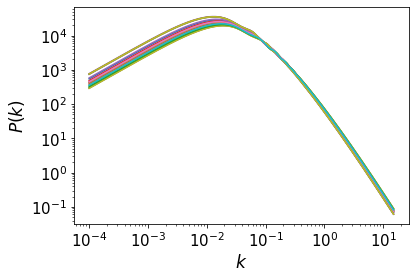

In [7]:
with np.load('../data/input_pk_h0_k300.npy') as data:
    h_lhs = data['H']
    kh = data['k']
    input_pk = data['pk']

print(np.shape(input_pk))
print(np.shape(h_lhs))

for i in range(20):
  plt.loglog(kh, input_pk[i])    
plt.xlabel("$k$", fontsize=17)
plt.ylabel("$P(k)$", fontsize=17)

Npoints = len(input_pk[0])  
print(h_lhs.min(), h_lhs.max())

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

xscaler = StandardScaler() #MinMaxScaler()
yscaler = StandardScaler() #MinMaxScaler()

scaled_input = xscaler.fit(h_lhs)
scaled_output = yscaler.fit(input_pk)

norm_x = scaled_input.transform(h_lhs)                               
norm_y = scaled_output.transform(input_pk)

print(norm_x.min(), norm_x.max())

norm_x = pd.DataFrame(norm_x)
norm_y = pd.DataFrame(norm_y)

x_train, x_test, y_train, y_test = train_test_split(norm_x,
                                                    norm_y,
                                                    test_size=0.3,
                                                    random_state=1273)

-1.7320347 1.731803


In [9]:
model_nn, history_nn = nn_architecture(x_train, y_train, Npoints, Nunits=200, lr=0.007, b_size=100, epchs=250, vrbs=0, v_split=0.3)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               60300     
Total params: 141,100
Trainable params: 141,100
Non-trainable params: 0
__________________________________________________

2022-06-19 10:42:07.836291: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-19 10:42:07.836841: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-19 10:42:07.841141: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-06-19 10:42:07.943503: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-19 10:42:07.959364: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300800000 Hz


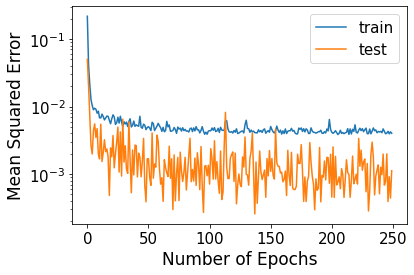

In [10]:
plt.plot(history_nn.history["loss"], label="train")
plt.plot(history_nn.history["val_loss"], label="test")
plt.xlabel("Number of Epochs", fontsize=17)
plt.ylabel("Mean Squared Error", fontsize=17)
plt.yscale("log")
plt.legend(fontsize=15)

# ICA - Dimensionality reduction

In [11]:
from sklearn.decomposition import FastICA

Ncomponents = 5

transformer = FastICA(n_components=Ncomponents,
                        random_state=0,
                        max_iter=10000)

pk_transformed = transformer.fit_transform(input_pk)

yica_scaler = StandardScaler() #MinMaxScaler()

ica_scaled_output = yica_scaler.fit(pk_transformed)
                              
norm_ica_y = ica_scaled_output.transform(pk_transformed)
print(norm_ica_y.min(), norm_ica_y.max())

norm_ica_y = pd.DataFrame(norm_ica_y)

x_ica_train, x_ica_test, y_ica_train, y_ica_test = train_test_split(norm_x,
                                                                    norm_ica_y,
                                                                    test_size=0.2,
                                                                    random_state=1273)

-5.168998519157864 1.7102263734165941


In [12]:
model_ica_nn, history_ica_nn = nn_architecture(x_ica_train, y_ica_train, Ncomponents, Nunits=200, lr=0.007, b_size=100, epchs=250, vrbs=0, v_split=0.3)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               400       
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 1005      
Total params: 81,805
Trainable params: 81,805
Non-trainable params: 0
__________________________________________________

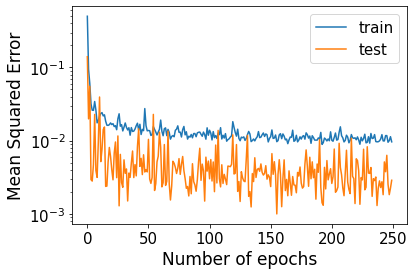

In [13]:
plt.plot(history_ica_nn.history["loss"], label="train")
plt.plot(history_ica_nn.history["val_loss"], label="test")
#plt.xlim([0, 500])
#plt.ylim([0, 0.15])
plt.xlabel("Number of epochs", fontsize=17)
#plt.ylabel("mean absolute error")
plt.ylabel("Mean Squared Error", fontsize=17)
plt.yscale("log")
plt.legend(fontsize=15)

# Comparison of NNs

In [14]:
s8_fid = 0.8102

HH0 = 61.3
new_H0 = np.reshape(np.array(HH0),(1, 1))
new_h = new_H0
input_scaled = scaled_input.transform(new_h)
print(input_scaled)

[[-1.00458796]]


In [15]:
predicted_pk = scaled_output.inverse_transform(model_nn.predict([input_scaled]))
output_pk_compare = pk_camb(HH0, kmin, kmax, Npoints, s8_fid)

predicted_ica_pk = ica_scaled_output.inverse_transform(model_ica_nn.predict([input_scaled]))
inverse_pk = transformer.inverse_transform(predicted_ica_pk)

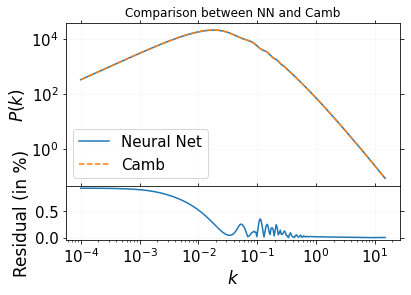

In [16]:
plot_pk(kh, predicted_pk, output_pk_compare, label1="Neural Net", label2="Camb")

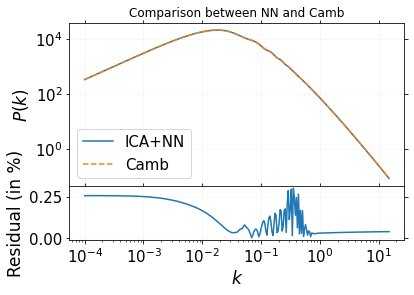

In [17]:
plot_pk(kh, inverse_pk, output_pk_compare, label1="ICA+NN", label2="Camb")

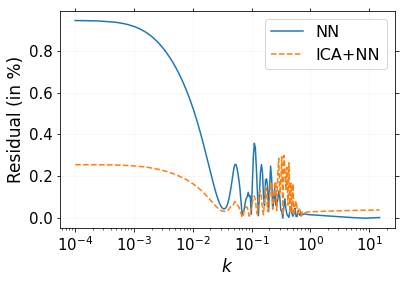

In [18]:
plt.plot(kh, np.abs((predicted_pk[0]-output_pk_compare[0])/output_pk_compare[0])*100, "C0-", label="NN")
plt.plot(kh, np.abs((inverse_pk[0]-output_pk_compare[0])/output_pk_compare[0])*100, "C1--", label="ICA+NN")
plt.xscale("log")
plt.legend(fontsize=16)
plt.grid(alpha=0.1)
plt.ylabel("Residual (in %)", fontsize=17)
plt.xlabel("$k$", fontsize=17)
plt.tick_params(top=True, right=True)